# This notebook serves three purposes

- Visually Unit Testing the results.
- Easy way to compare a case
- Working through the guidelines mentioned in: Paper

# Nomenclature

| Metric             | Description |
|--------------------|-------------|
| PQ                 | Panoptic Quality Metrics |
| CC                 | CC Metrics |
| Lw                 | Lesionwise Metrics |
| C                  | Cluster Metrics |
| mm                | Maximise Merge Metrics |
| b                  | Blob Metrics |

---

| Symbol            | Meaning      |
|-------------------|--------------|
| ✅                | Ideal        |
| ⚠️                | Non-ideal setting, but not *wrong* |
| ❌                | *Wrong*      |


# Code Begins

## Imports

### Common Ones

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

from typing import List, Optional
import warnings

warnings.filterwarnings("ignore")

### Metrics

In [2]:
# Semantic Metrics
from metrics.semantic.intersection_over_union import multiclass_iou
from metrics.semantic.dice_score_coefficient import multiclass_dsc
from metrics.semantic.normalised_surface_dice import multiclass_nsd

# Instance Sensitive Metrics
from metrics.instance.panoptic import pq_metric
from metrics.instance.region import cc_metric
from metrics.instance.lesionwise import lw_metric
from metrics.instance.maxmerge import mm_metric
from metrics.instance.cluster import cluster_metric
from metrics.instance.multimaxmerge import mmm_metric
from metrics.instance.blob import blob_metric

# tools
from metrics.tools.connected_components import gpu_connected_components
from metrics.tools.one_hot_encoding import one_hot_encode
from metrics.tools.labelling import label

## Helper functions for smooth testing

### Tally scores

In [3]:

def score_list(
    pred: List, 
    gt: List,
    metrics: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Compute evaluation scores for a list of predictions and ground truths.
    
    Args:
        predictions: List of predicted segmentations
        ground_truths: List of ground truth segmentations
        metrics: Optional list of metrics to compute (default: all available)
        
    Returns:
        DataFrame containing computed scores for each metric
    """

    # Get instance information
    _, num_gt_instances = gpu_connected_components(gt)
    
    # Determine number of classes from predictions
    num_classes = int(pred.max() + 1)
    
    # Prepare data representations
    pred_one_hot = one_hot_encode(pred, num_classes)
    gt_one_hot = one_hot_encode(gt, num_classes)
    
    pred_labels = label(pred, num_classes)
    gt_labels = label(gt, num_classes)
    
    # Define available metrics
    available_metrics = ['dsc', 'iou', 'nsd']
    metrics_to_compute = metrics if metrics else available_metrics

    """
    PQ - Panoptic Metrics
    CC - CC Metrics
    LW - Lesionwise Metrics
    MM - MaxMerge Metrics
    C - Cluster Metrics
    MMM - MultiMaxMerge Metrics
    B - Blob Metrics
    """
    
    # Define instance evaluation methods
    instance_evaluation_methods = {
        'PQ': lambda pred, gt, metric: pq_metric(pred, gt, metric=metric),
        'CC': lambda pred, gt, metric: cc_metric(pred, gt, metric=metric),
        'LW': lambda pred, gt, metric: lw_metric(pred, gt, num_gt_instances, metric=metric),
        'MM': lambda pred, gt, metric: mm_metric(pred, gt, metric=metric),
        'C': lambda pred, gt, metric: cluster_metric(pred, gt, metric=metric),
        'MMM': lambda pred, gt, metric: mmm_metric(pred, gt, metric=metric),
        'B': lambda pred, gt, metric: blob_metric(pred, gt, metric=metric),
    }
    
    # Compute all metrics
    results = {
        'Metric': list(instance_evaluation_methods.keys())
    }
    
    # Calculate each instance metric
    for metric in metrics_to_compute:
        # For each evaluation method, decide which input arguments to use
        # (some methods use one_hot encodings, others use labels)
        results[metric] = []
        
        for method_name, method_func in instance_evaluation_methods.items():
            if method_name in ['PQ', 'LW', 'MM']:
                # These methods use labeled data
                score = method_func(pred_labels, gt_labels, metric)
            elif method_name in ['CC', 'B']:
                # These methods use one-hot and labels
                score = method_func(pred_one_hot, gt_labels, metric)
            else:
                # These methods use one-hot encodings
                score = method_func(pred_one_hot, gt_one_hot, metric)
                
            results[metric].append(score)
    
    # Define Semantic evaluation methods
    semantic_evaluation_methods = {
        'DSC': lambda pred, gt: multiclass_dsc(pred, gt),
        'IoU': lambda pred, gt: multiclass_iou(pred, gt),
        'NSD': lambda pred, gt: multiclass_nsd(pred, gt),
    }

    # Calculate each semantic metric
    semantic_dice = semantic_evaluation_methods['DSC'](pred_one_hot, gt_one_hot).item()
    semantic_iou = semantic_evaluation_methods['IoU'](pred_one_hot, gt_one_hot).item()
    semantic_nsd = semantic_evaluation_methods['NSD'](pred_one_hot, gt_one_hot)

    new_row = {'Metric': 'Semantic', 'dsc': semantic_dice, 'iou': semantic_iou, 'nsd': semantic_nsd}
    results['Metric'].append(new_row['Metric'])
    results['dsc'].append(new_row['dsc'])
    results['iou'].append(new_row['iou'])
    results['nsd'].append(new_row['nsd'])

    # Create and return DataFrame
    df = pd.DataFrame(results)
    print(df.to_string(index=False))

### Visual Plot of Case

In [4]:
def plot_case(pred, gt, num_classes=8):
    """
    Visualize prediction, ground truth, and a detailed confusion visualization using seaborn styling with pastel colors.

    Args:
        pred: Prediction tensor (class indices)
        gt: Ground truth tensor (class indices)
        num_classes: Number of classes (including background)
    """

    # Set seaborn style
    sns.set(style="whitegrid", context="talk")
    plt.rcParams["axes.edgecolor"] = "0.2"
    plt.rcParams["axes.linewidth"] = 1.5

    # Convert tensors to numpy if they aren't already
    pred_np = pred.cpu().numpy() if hasattr(pred, "cpu") else pred
    gt_np = gt.cpu().numpy() if hasattr(gt, "cpu") else gt

    # Define fixed pastel colors for consistent appearance
    background_color = [0.97, 0.97, 0.97, 1]

    # Use VIBGYOR color palette for classes
    pastel_class_colors = [
        background_color,  # Class 0 (background)
        [0.85, 0.41, 0.43, 1.0],  # Class 1 (darker pastel red)
        [0.88, 0.58, 0.40, 1.0],  # Class 2 (darker pastel orange)
        [0.92, 0.77, 0.5, 1.0],  # Class 3 (darker pastel yellow)
        [0.6, 0.75, 0.55, 1.0],  # Class 4 (darker pastel green)
        [0.55, 0.67, 0.83, 1.0],  # Class 5 (darker pastel blue)
        [0.65, 0.5, 0.75, 1.0],  # Class 6 (darker pastel indigo)
        [0.75, 0.55, 0.75, 1.0],  # Class 7 (darker pastel violet)
    ]

    # If num_classes > 7, extend with additional pastel colors
    if num_classes > 7:
        additional_colors = sns.color_palette("pastel", num_classes - 7)
        class_colors = pastel_class_colors + [
            (*color, 1.0) for color in additional_colors
        ]
    else:
        class_colors = pastel_class_colors[:num_classes]

    class_cmap = mcolors.ListedColormap(class_colors)
    class_norm = mcolors.BoundaryNorm(
        boundaries=np.arange(num_classes + 1) - 0.5, ncolors=num_classes
    )

    # Create confusion visualization matrix
    confusion_vis = np.zeros_like(pred_np)

    # Define confusion colors (fixed for all classes)
    tp_color = [0.77, 0.60, 0.43, 1.0]  # Pastel Brown for TP
    fp_color = [0.95, 0.70, 0.80, 1.0]  # Pastel Pink for FP
    fn_color = [0.85, 0.71, 0.85, 1.0]  # Pastel Purple for FN

    # Build confusion colors array
    confusion_colors = np.zeros((3 * num_classes, 4))  # RGBA colors
    confusion_colors[0] = background_color  # Background (True Negatives)

    # Apply these fixed pastel colors to all classes
    for c in range(1, num_classes):
        # Assign colors to TP/FP/FN categories
        confusion_colors[c] = tp_color  # True positives
        confusion_colors[c + num_classes] = fp_color  # False positives
        confusion_colors[c + 2 * num_classes] = fn_color  # False negatives

        # Fill confusion visualization matrix
        tp_mask = (pred_np == c) & (gt_np == c)
        fp_mask = (pred_np == c) & (gt_np != c)
        fn_mask = (pred_np != c) & (gt_np == c)

        confusion_vis[tp_mask] = c
        confusion_vis[fp_mask] = c + num_classes
        confusion_vis[fn_mask] = c + 2 * num_classes

    confusion_cmap = mcolors.ListedColormap(confusion_colors)
    confusion_norm = mcolors.BoundaryNorm(
        boundaries=np.arange(3 * num_classes + 1) - 0.5, ncolors=3 * num_classes
    )

    # Create figure with better spacing and seaborn style
    fig, ax = plt.subplots(1, 3, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.5)

    # Plot prediction, ground truth, and confusion visualization
    im0 = ax[0].imshow(
        pred_np, cmap=class_cmap, norm=class_norm, interpolation="nearest"
    )
    ax[0].set_title("Pred", fontsize=26, pad=15)
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])

    im1 = ax[1].imshow(gt_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[1].set_title("GT", fontsize=26, pad=15)
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])

    im2 = ax[2].imshow(
        confusion_vis, cmap=confusion_cmap, norm=confusion_norm, interpolation="nearest"
    )
    ax[2].set_title("Overlay", fontsize=26, pad=15)
    ax[2].set_xticklabels([])
    ax[2].set_yticklabels([])

    # Add colorbar for class visualization
    cbar_ax1 = fig.add_axes([0.295, 0.15, 0.025, 0.7])
    cbar1 = fig.colorbar(im0, cax=cbar_ax1)
    cbar1.set_ticks(np.arange(num_classes))
    cbar1.set_ticklabels([f"Class {i}" for i in range(num_classes)])
    cbar1.ax.tick_params(labelsize=12)

    # Add legend
    legend_elements = [
        Patch(facecolor=background_color, edgecolor="#dddddd", label="Background (TN)"),
        Patch(facecolor=tp_color, edgecolor="#dddddd", label="True Positives"),
        Patch(facecolor=fp_color, edgecolor="#dddddd", label="False Positives"),
        Patch(facecolor=fn_color, edgecolor="#dddddd", label="False Negatives"),
    ]

    legend = fig.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(1.15, 1),
        fontsize=21,
        frameon=True,
        framealpha=0.95,
        edgecolor="#dddddd",
        title="Overlay",
        title_fontsize=21,
    )
    legend.get_frame().set_facecolor("#f8f9fa")

    # Add borders around the plots
    for a in ax:
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_color("#dddddd")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)  # Readjust after tight_layout

    plt.show()

    return fig, ax

## Simple Binary Case showing 
- instance imbalance, and 
- difference between instance-sensitive and global metrics

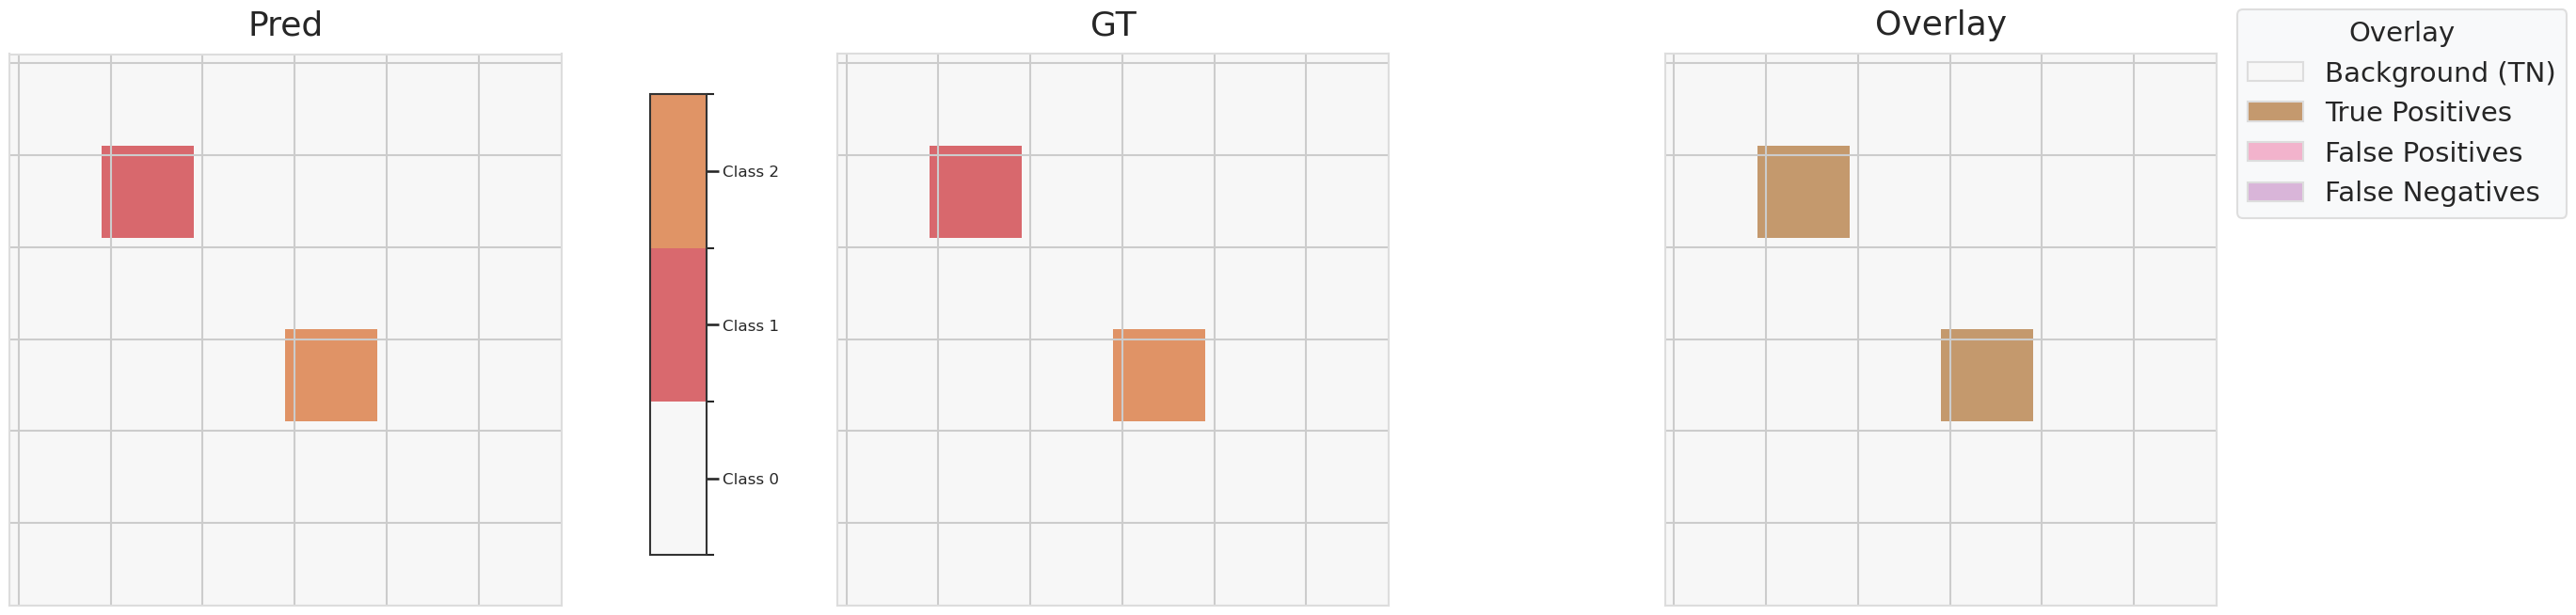

tensor([1., 1.], device='cuda:0')
  Metric  dsc  iou  nsd
      PQ  1.0  1.0  1.0
      CC  1.0  1.0  1.0
      LW  1.0  1.0  1.0
      MM  1.0  1.0  1.0
       C  1.0  1.0  1.0
     MMM  1.0  1.0  1.0
       B  1.0  1.0  1.0
Semantic  1.0  1.0  1.0


In [5]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

pred[5:10, 5:10] = 1
pred[15:20, 15:20] = 2

gt[5:10, 5:10] = 1
gt[15:20, 15:20] = 2

plot_case(pred, gt, num_classes=3)

# Move tensors to CPU before calling score_list
score_list(pred, gt)

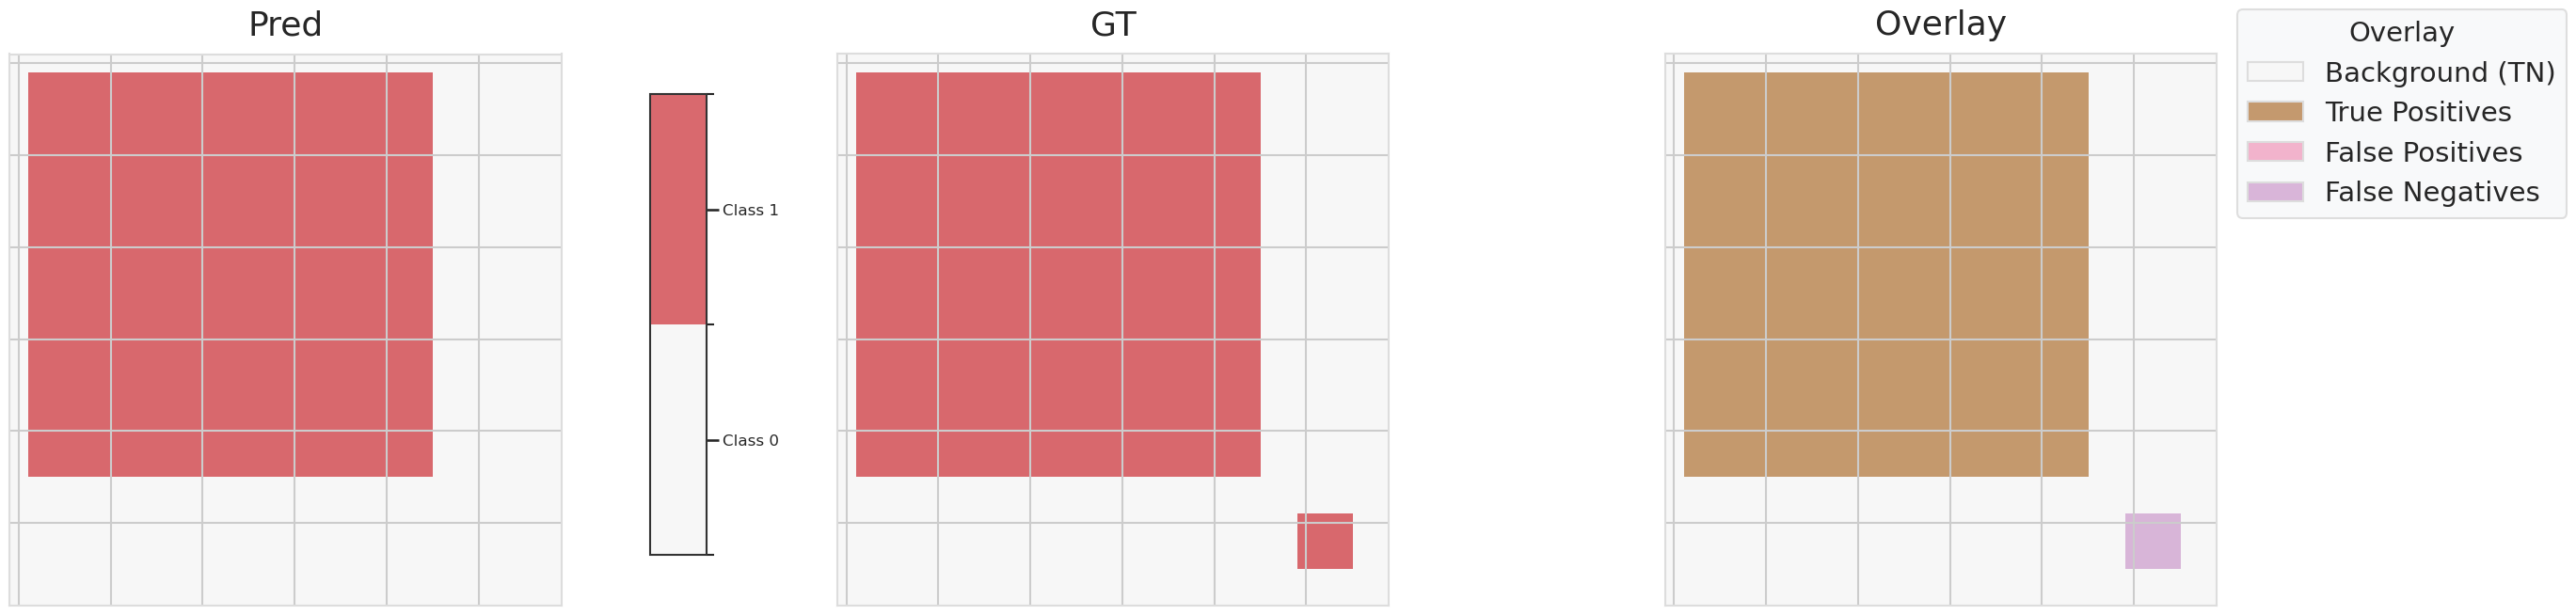

tensor([0.9908], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.500000 0.500000 0.500000
      CC 0.500000 0.500000 0.500000
      LW 0.500000 0.500000 0.500000
      MM 0.500000 0.500000 0.500000
       C 0.500000 0.500000 0.500000
     MMM 0.500000 0.500000 0.500000
       B 0.500000 0.500000 0.500000
Semantic 0.990788 0.981744 0.954545


In [6]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

pred[1:23, 1:23] = 1
gt[1:23, 1:23] = 1

# pred[25:28, 27:31] = 1
gt[25:28, 25:28] = 1

plot_case(pred, gt, num_classes=2)

# Move tensors to CPU before calling score_list
score_list(pred, gt)

# Simple Multi-Class Case

In [7]:
# # Sample Data
# pred = torch.zeros((30, 30)).cuda()
# gt = torch.zeros((30, 30)).cuda()

# # Class 1 - Both pred and gt have the same region
# pred[1:5, 1:5] = 1
# gt[1:5, 1:5] = 1

# # Class 1 - Both pred and gt have the same region
# pred[7:11, 7:11] = 1
# gt[7:11, 7:11] = 1

# # Class 2 - Different regions in pred and gt
# pred[25:32, 5:10] = 2
# gt[25:32, 7:12] = 2  # Slight offset for partial overlap

# # Class 3 - Completely different regions
# pred[5:10, 25:32] = 3
# gt[7:12, 27:34] = 3

# # Class 4 - No prediction, only ground truth
# gt[25:28, 25:28] = 4

# # Class 5 - Only prediction, no ground truth
# pred[15:20, 25:30] = 5

# # Class 6 - Both pred and gt have the same region
# pred[15:20, 15:20] = 6
# gt[15:20, 15:20] = 6

# # Class 7 - Both pred and gt have the same region
# pred[25:30, 15:20] = 7
# gt[25:30, 15:20] = 7

# plot_case(pred, gt, num_classes=8)
# score_list(pred, gt)

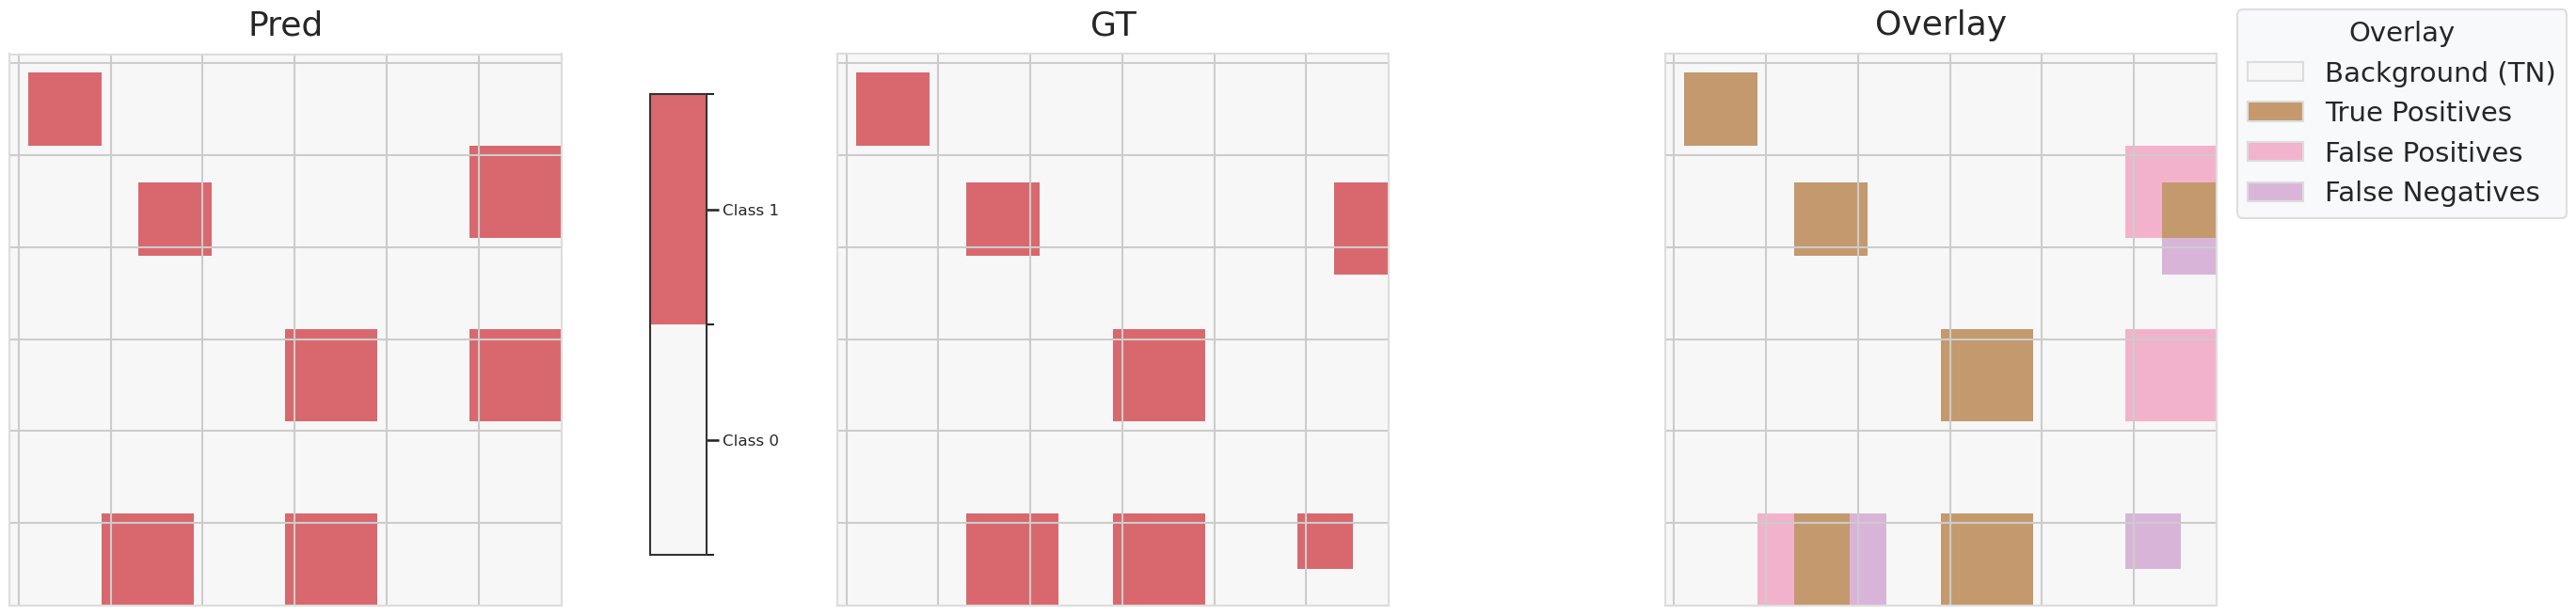

tensor([0.7361], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.631250 0.589862 0.645089
      CC 0.691674 0.639734 0.698413
      LW 0.631250 0.589862 0.645089
      MM 0.631250 0.589862 0.645089
       C 0.631250 0.589862 0.645089
     MMM 0.631250 0.589862 0.645089
       B 0.332979 0.209891 0.315773
Semantic 0.736111 0.582418 0.750000


In [8]:
# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 1
gt[25:32, 7:12] = 1  # Slight offset for partial overlap

# Class 3 - Completely different regions
pred[5:10, 25:32] = 1
gt[7:12, 27:34] = 1

# Class 4 - No prediction, only ground truth
gt[25:28, 25:28] = 1

# Class 5 - Only prediction, no ground truth
pred[15:20, 25:30] = 1

# Class 6 - Both pred and gt have the same region
pred[15:20, 15:20] = 1
gt[15:20, 15:20] = 1

# Class 7 - Both pred and gt have the same region
pred[25:30, 15:20] = 1
gt[25:30, 15:20] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

# Cases and Guidelines discussion

To kick things off, we want to discuss the guidelines points which do not need visual representation. (The details are in the paper.)

Guideline Point 1: Do all the metrics adhere to the original panoptic Guidlines? - Yes. \

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ✅  | ✅  | ✅  | ✅  | ✅  |

Guideline Point 2: Does it consider *every* prediction instance to build the metric?

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ⚠️   | ✅  | ✅  | ✅  | ⚠️   | ✅  |

Guideline Point 3: Does it *only* need instance formation of GT?

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ⚠️   | ✅  | ⚠️   | ⚠️   | ⚠️   | ✅  |

## Guideline Point 4: Are all instances *always* equally weighed

<ins>Guide Description:</ins> Is each instance weighed equally in all cases. 

<ins> How are we showing this:</ins> By highlighting the specifc case discussed on why CC Fails. Notice:
-  the the CC Score is similar ot the global scores, and 
-  how all other instance-sensitive metrics have the same score.

<ins>Why CC Fails:</ins> In this particular case, 1 GT and Many Pred, the the region of 1 GT covers the entire volume. This means that the instance weighing for the pred instances disappears. Hence it behaves like a global metric becasue 

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ❌  | ✅  | ✅  | ✅  | ❌  |

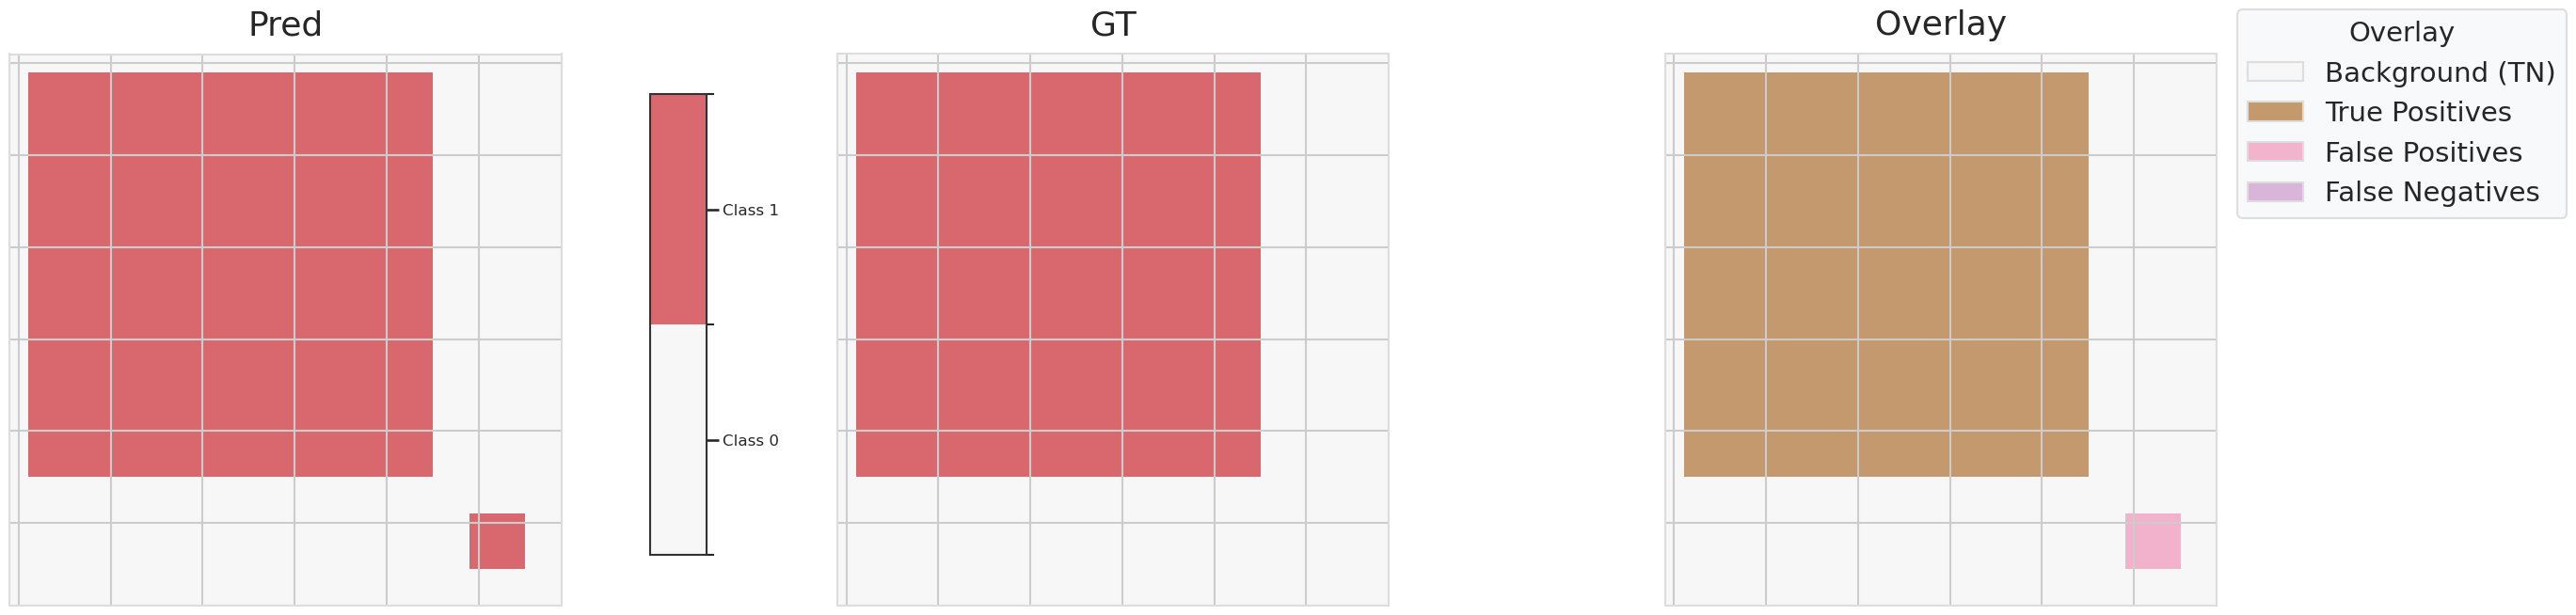

tensor([0.9908], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.500000 0.500000 0.500000
      CC 0.990788 0.981744 0.954545
      LW 0.500000 0.500000 0.500000
      MM 0.500000 0.500000 0.500000
       C 0.500000 0.500000 0.500000
     MMM 0.500000 0.500000 0.500000
       B 0.990788 0.981744 0.954545
Semantic 0.990788 0.981744 0.954545


In [9]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

gt[1:23, 1:23] = 1
pred[1:23, 1:23] = 1

pred[25:28, 25:28] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

## Guideline Point 5: Are multiple classes evaluated *inherently*?

<ins>Guide Description:</ins> Do scores drastically differ if the same case is posed in multiple classes? 

<ins> How are we showing this?:</ins> By comparing a simple case in binary and muilti-class and showing the score difference in both.

<ins>Why tick sign for PQ and Lw?</ins> As they rely on the counts of all classes, they are inherently multi-class.

<ins>Why Warning Sign for others?</ins> Ideally, we would want the inherent evaluation of multiple classes, and not a simple mean.

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ✅  | ⚠️  | ✅   | ⚠️   | ⚠️   | ⚠️   |

Multi-Class Case


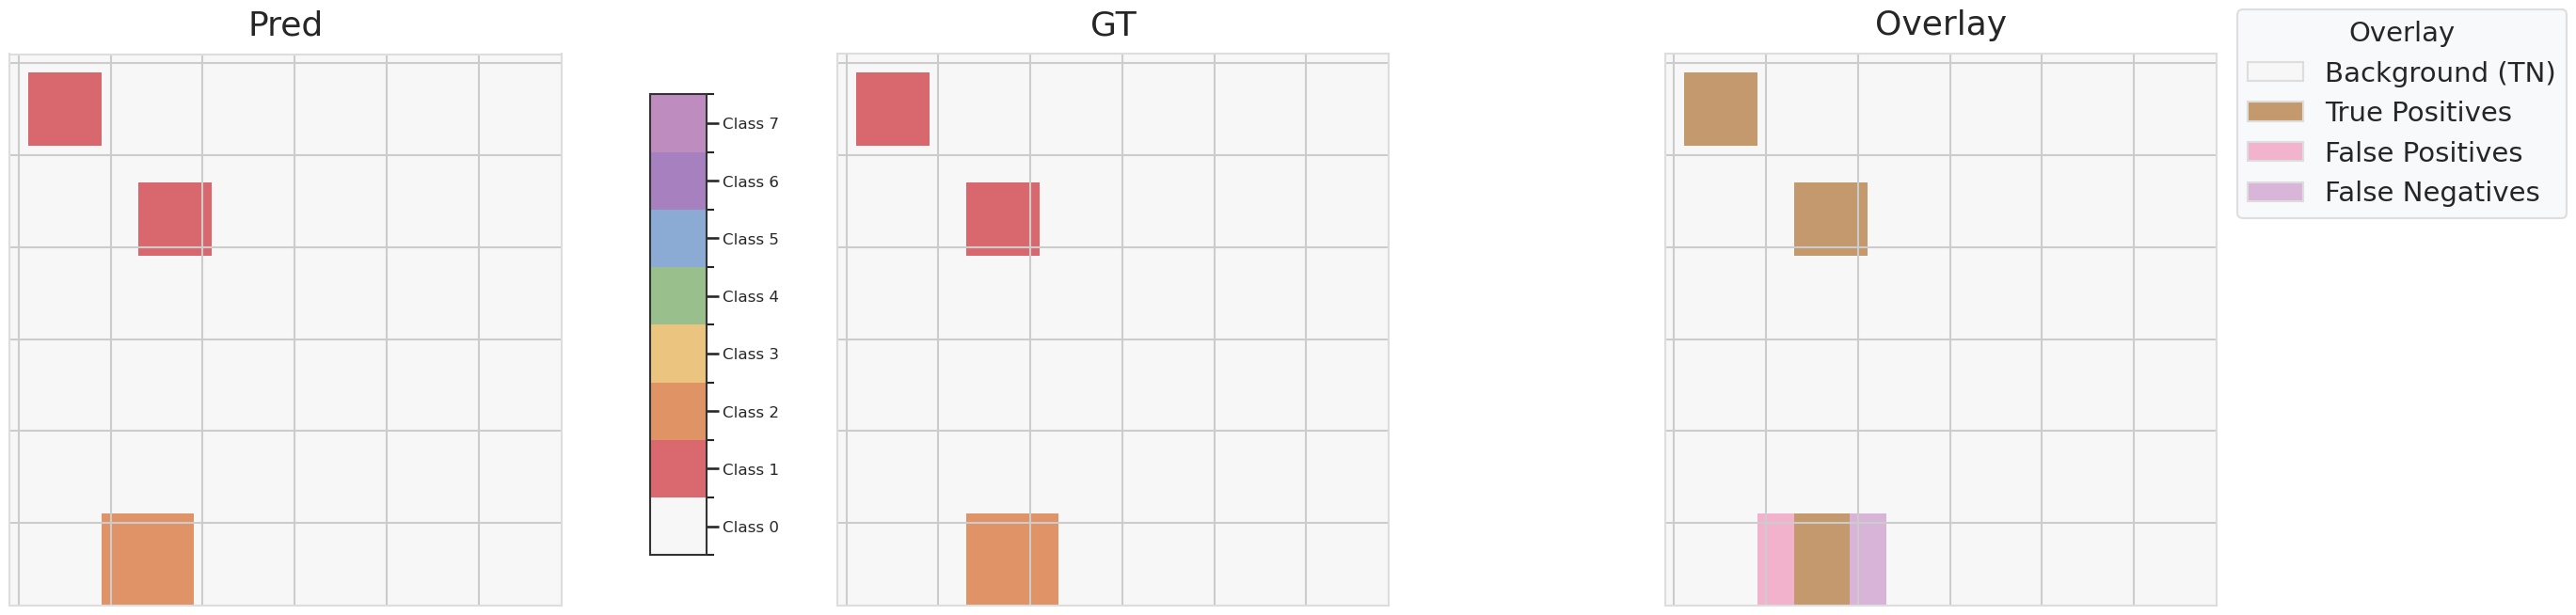

tensor([1.0000, 0.6000], device='cuda:0')
  Metric      dsc      iou    nsd
      PQ 0.866667 0.809524 0.8750
      CC 0.800000 0.714286 0.8125
      LW 0.866667 0.809524 0.8750
      MM 0.866667 0.809524 0.8750
       C 0.800000 0.714286 0.8125
     MMM 0.800000 0.714286 0.8125
       B 0.800000 0.714286 0.8125
Semantic 0.800000 0.714286 0.8125


In [10]:
print("Multi-Class Case")

# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 2
gt[25:32, 7:12] = 2  # Slight offset for partial overlap

plot_case(pred, gt, num_classes=8)
score_list(pred, gt)

Multi-Binary Case


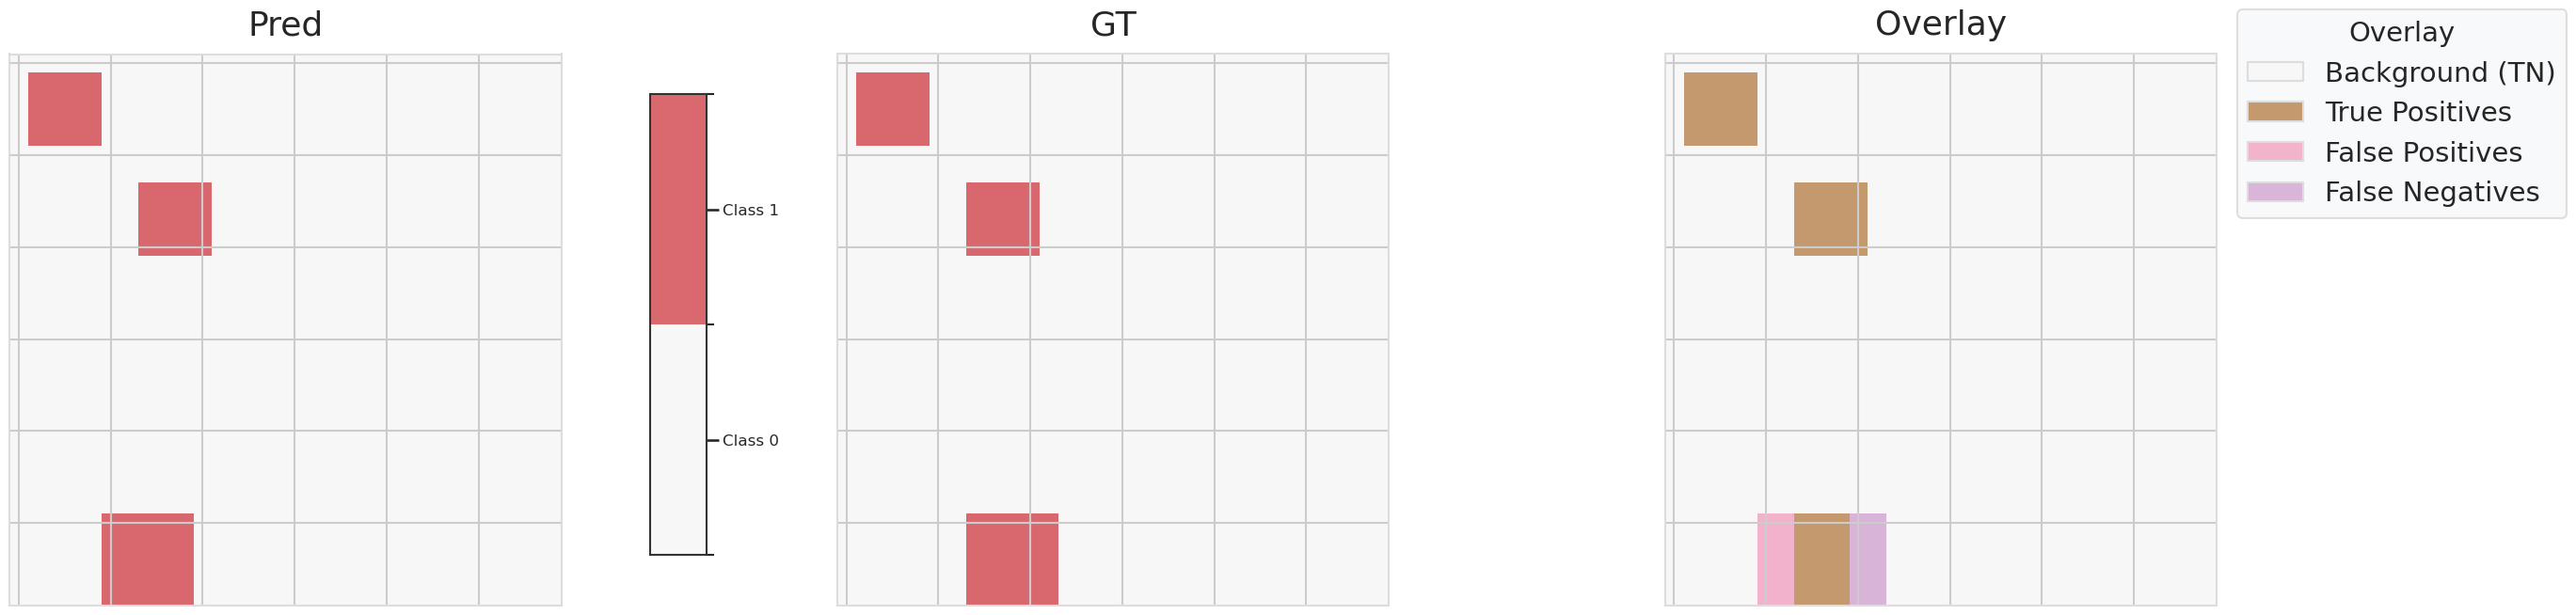

tensor([0.8246], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.866667 0.809524 0.875000
      CC 0.866667 0.809524 0.875000
      LW 0.866667 0.809524 0.875000
      MM 0.866667 0.809524 0.875000
       C 0.866667 0.809524 0.875000
     MMM 0.866667 0.809524 0.875000
       B 0.707937 0.553114 0.678922
Semantic 0.824561 0.701493 0.850000


In [11]:
print("Multi-Binary Case")

# Sample Data
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Class 1 - Both pred and gt have the same region
pred[1:5, 1:5] = 1
gt[1:5, 1:5] = 1

# Class 1 - Both pred and gt have the same region
pred[7:11, 7:11] = 1
gt[7:11, 7:11] = 1

# Class 2 - Different regions in pred and gt
pred[25:32, 5:10] = 1
gt[25:32, 7:12] = 1  # Slight offset for partial overlap

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

## Guideline Point 6: Is there semantic stability?

<ins>Guide Description:</ins> Throughout the metric computation, does a pixel have the same count assignment?

<ins> How are we showing this?:</ins> By choosing a case which highlights the shift in count assignment of the pixel. Difficult to notice from the score itself so details in the paper. Here we just show the case we discuss in the paper.

<ins>Sign Assignment</ins> Self explanatory.

| Metric | PQ  | CC  | Lw  | C   | mm  | b   |
|--------|-----|-----|-----|-----|-----|-----|
| Result | ❌  | ✅  | ❌  | ✅  | ✅  | ❌  |

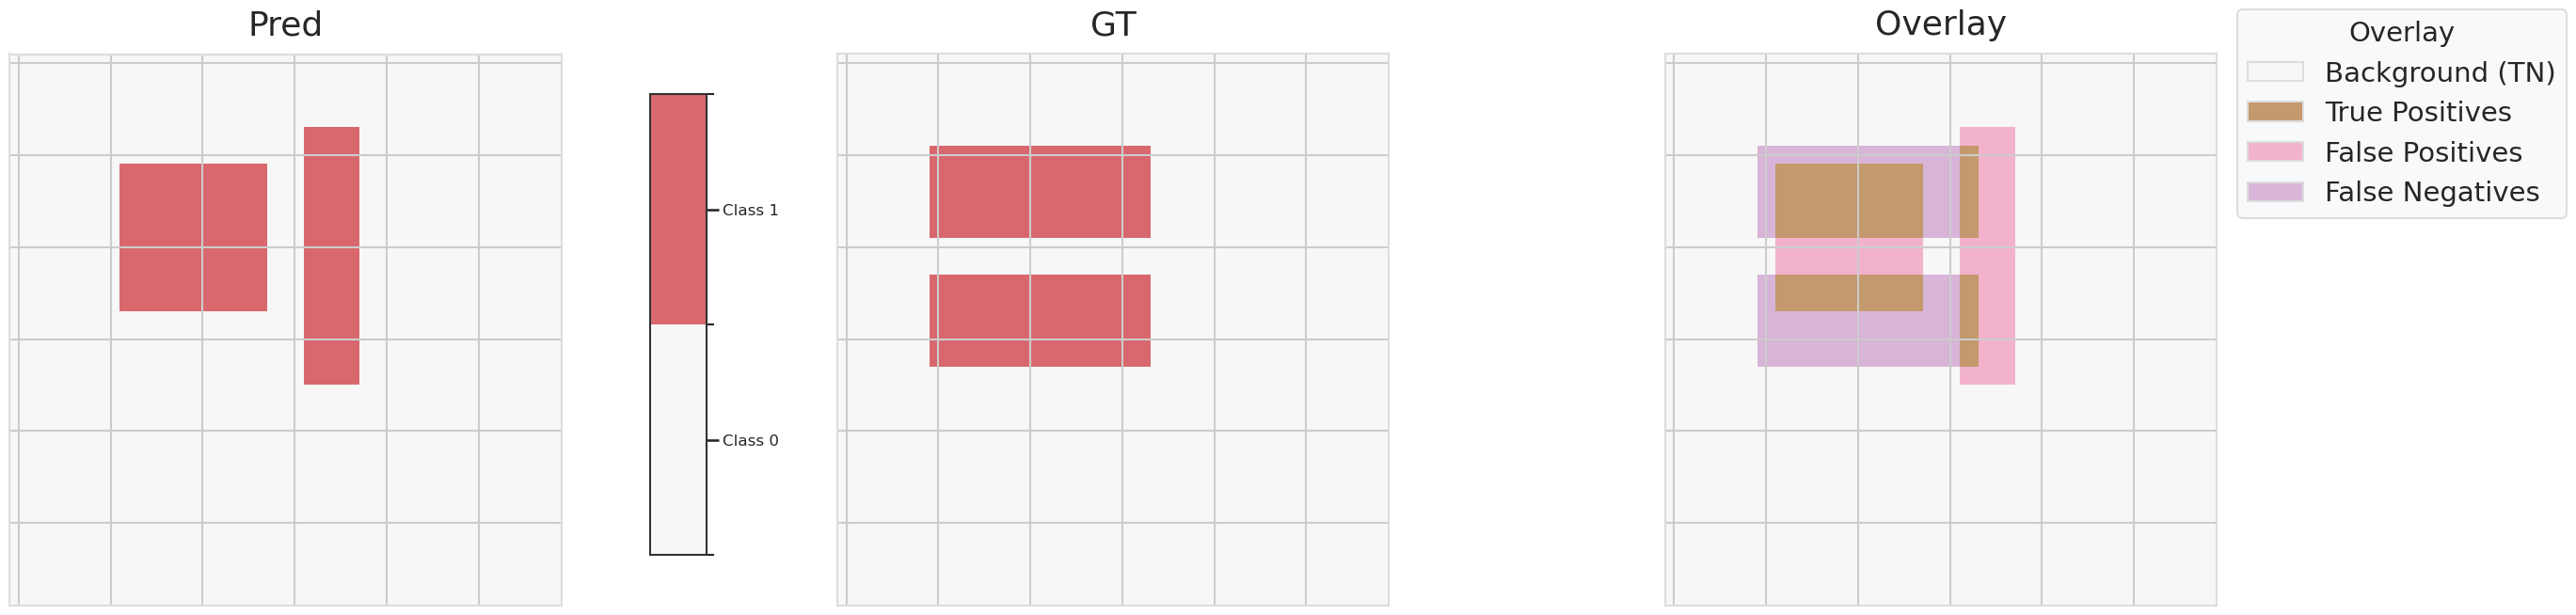

tensor([0.5133], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.307084 0.199686 0.392529
      CC 0.505785 0.345238 0.747702
      LW 0.349398 0.215825 0.471591
      MM 0.307084 0.199686 0.486089
       C 0.513274 0.345238 0.703390
     MMM 0.521739 0.352941 0.703390
       B 0.417963 0.268519 0.505060
Semantic 0.513274 0.345238 0.703390


In [12]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

pred[4:18, 16:19] = 1

pred[6:14, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

# A nice case to show the use case of mmDICE

## Removing multiple predictions

Notice the decreasing score of CDice in every cell but not mmDice.

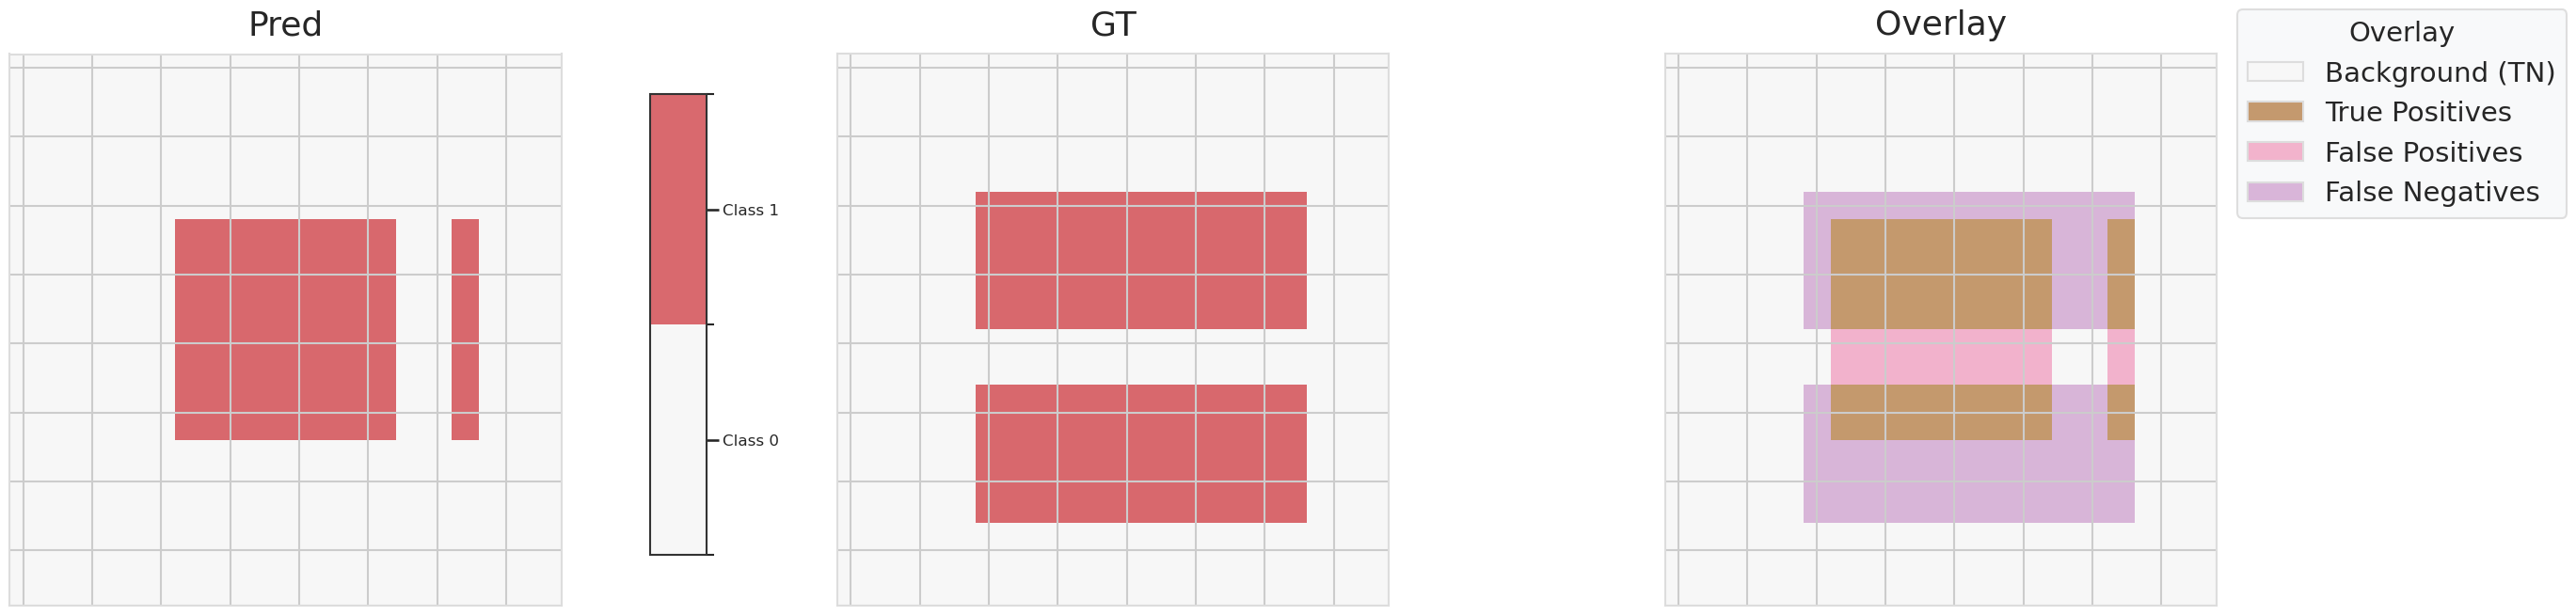

tensor([0.5625], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.287476 0.189065 0.367967
      CC 0.549754 0.391304 0.817853
      LW 0.409091 0.266447 0.553030
      MM 0.545455 0.375000 0.651515
       C 0.562500 0.391304 0.760417
     MMM 0.562500 0.391304 0.760417
       B 0.503289 0.346154 0.636111
Semantic 0.562500 0.391304 0.760417


In [13]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()


# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1


plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

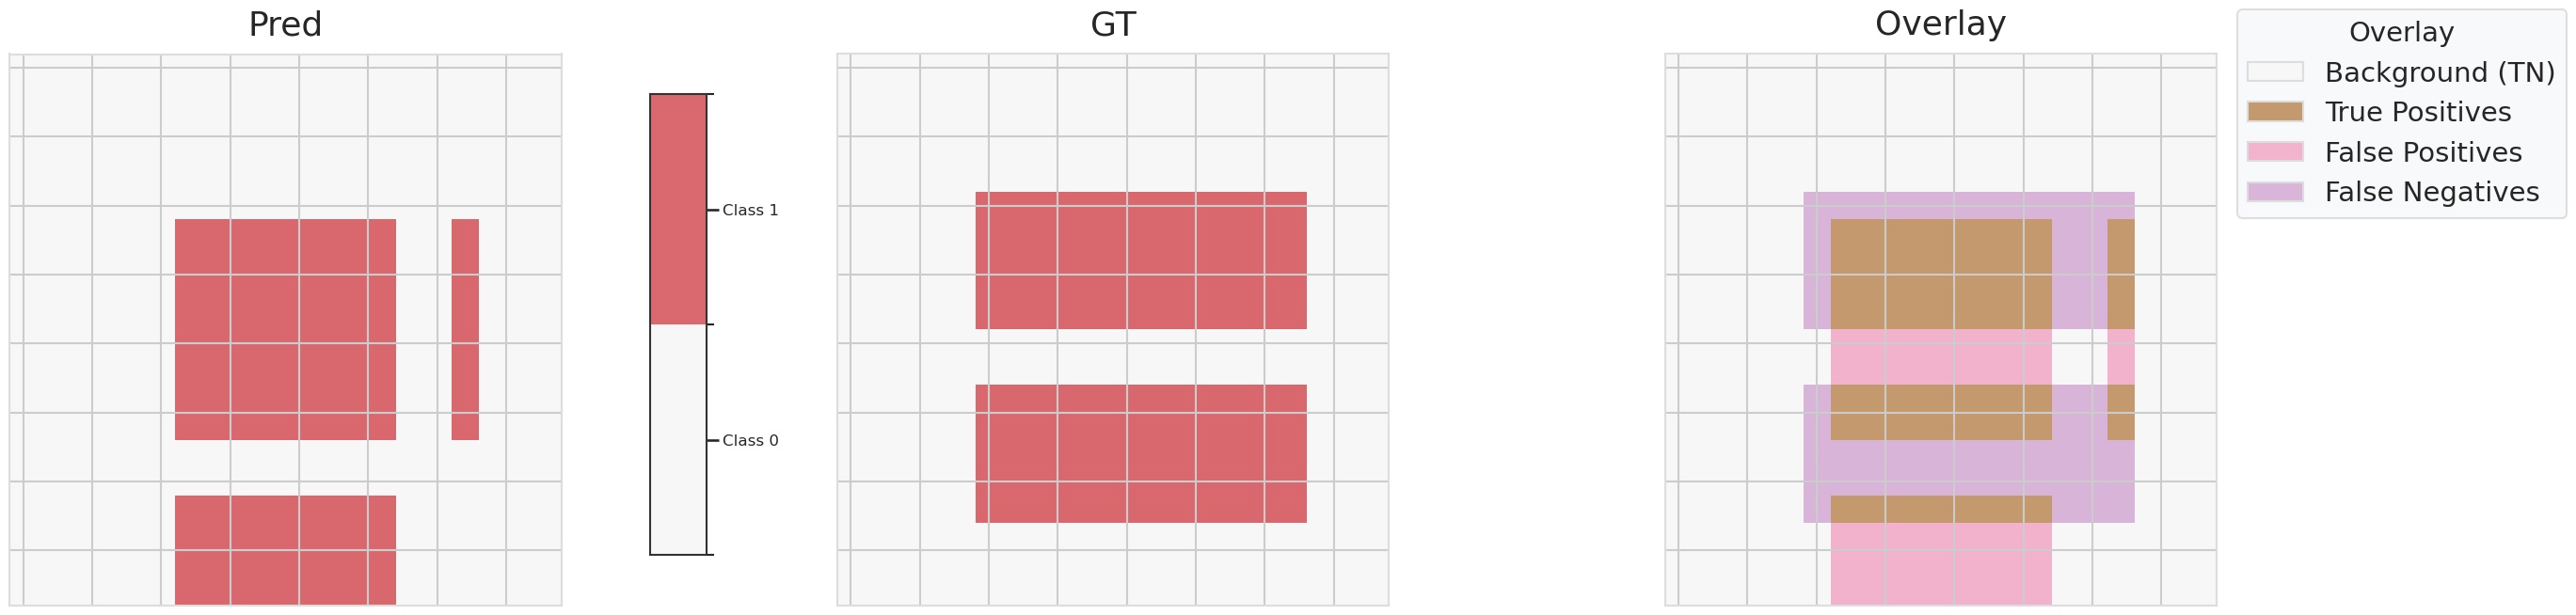

tensor([0.5536], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.345021 0.221532 0.475862
      CC 0.561345 0.400654 0.859279
      LW 0.431264 0.281703 0.616455
      MM 0.545455 0.375000 0.651515
       C 0.553571 0.382716 0.801724
     MMM 0.562500 0.391304 0.801724
       B 0.463995 0.303922 0.613479
Semantic 0.553571 0.382716 0.801724


In [14]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

# Bad Pred
pred[16:20, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

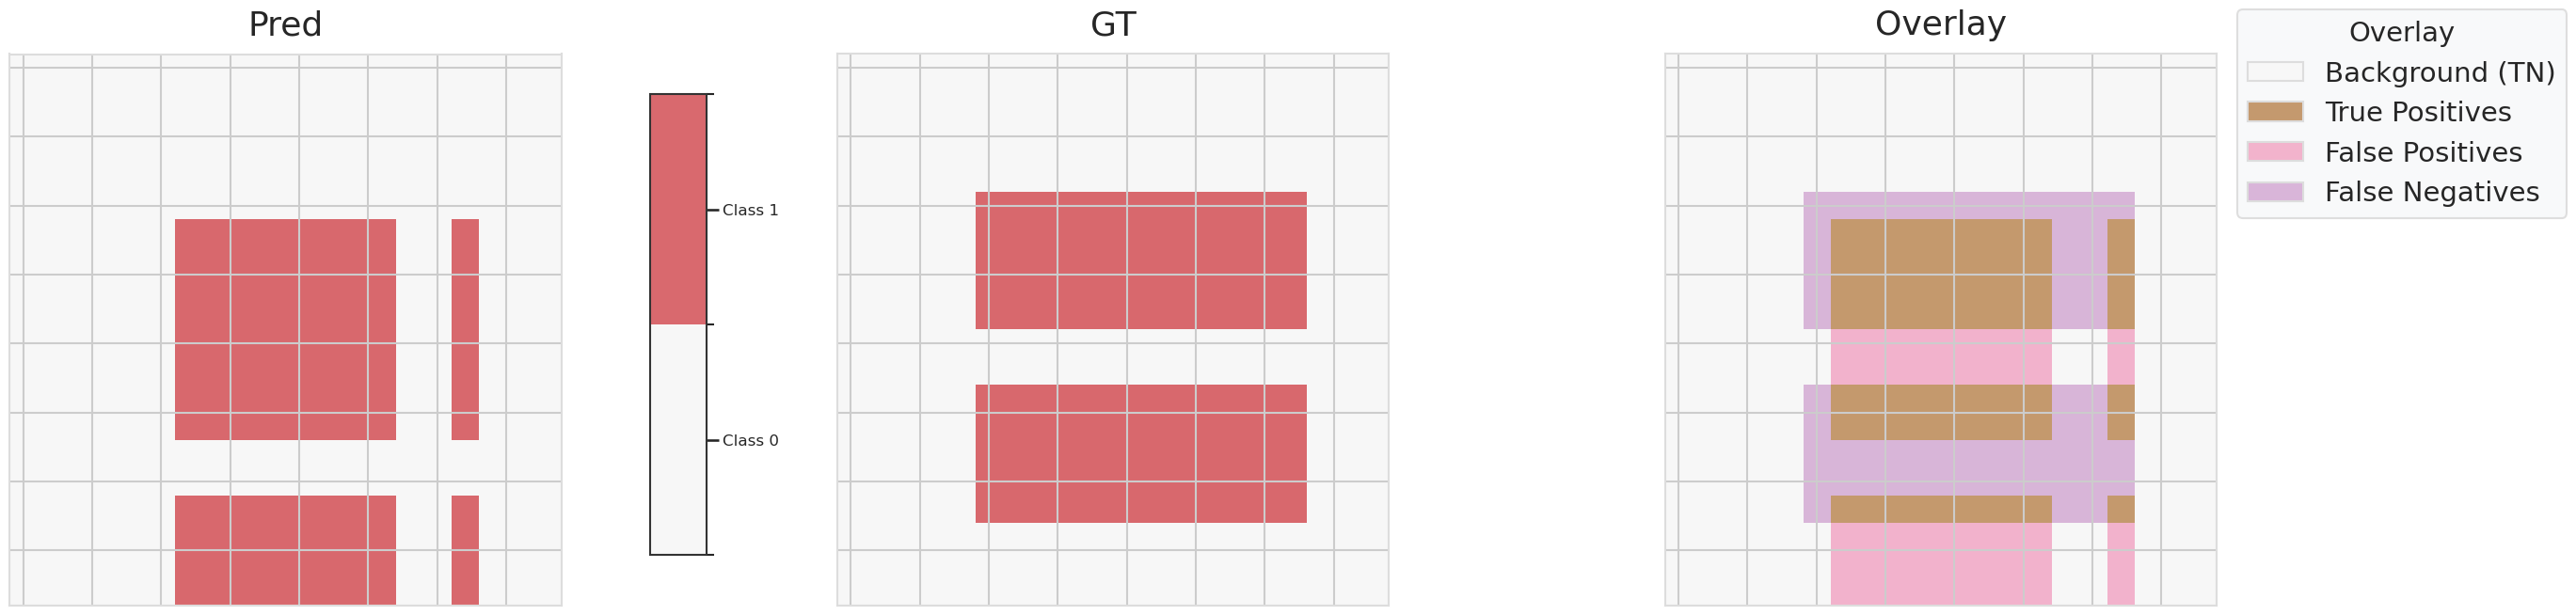

tensor([0.5526], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.345021 0.221532 0.475862
      CC 0.562369 0.401495 0.871579
      LW 0.433442 0.283245 0.631313
      MM 0.545455 0.375000 0.651515
       C 0.552632 0.381818 0.816667
     MMM 0.562500 0.391304 0.816667
       B 0.459865 0.300000 0.617996
Semantic 0.552632 0.381818 0.816667


In [15]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

# Bad Pred
pred[16:20, 6:14] = 1

# Bad Pred
pred[16:20, 16:17] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred,gt)

## Keeping Multiple predictions

Notice the drop when removing the prediction in the second cell

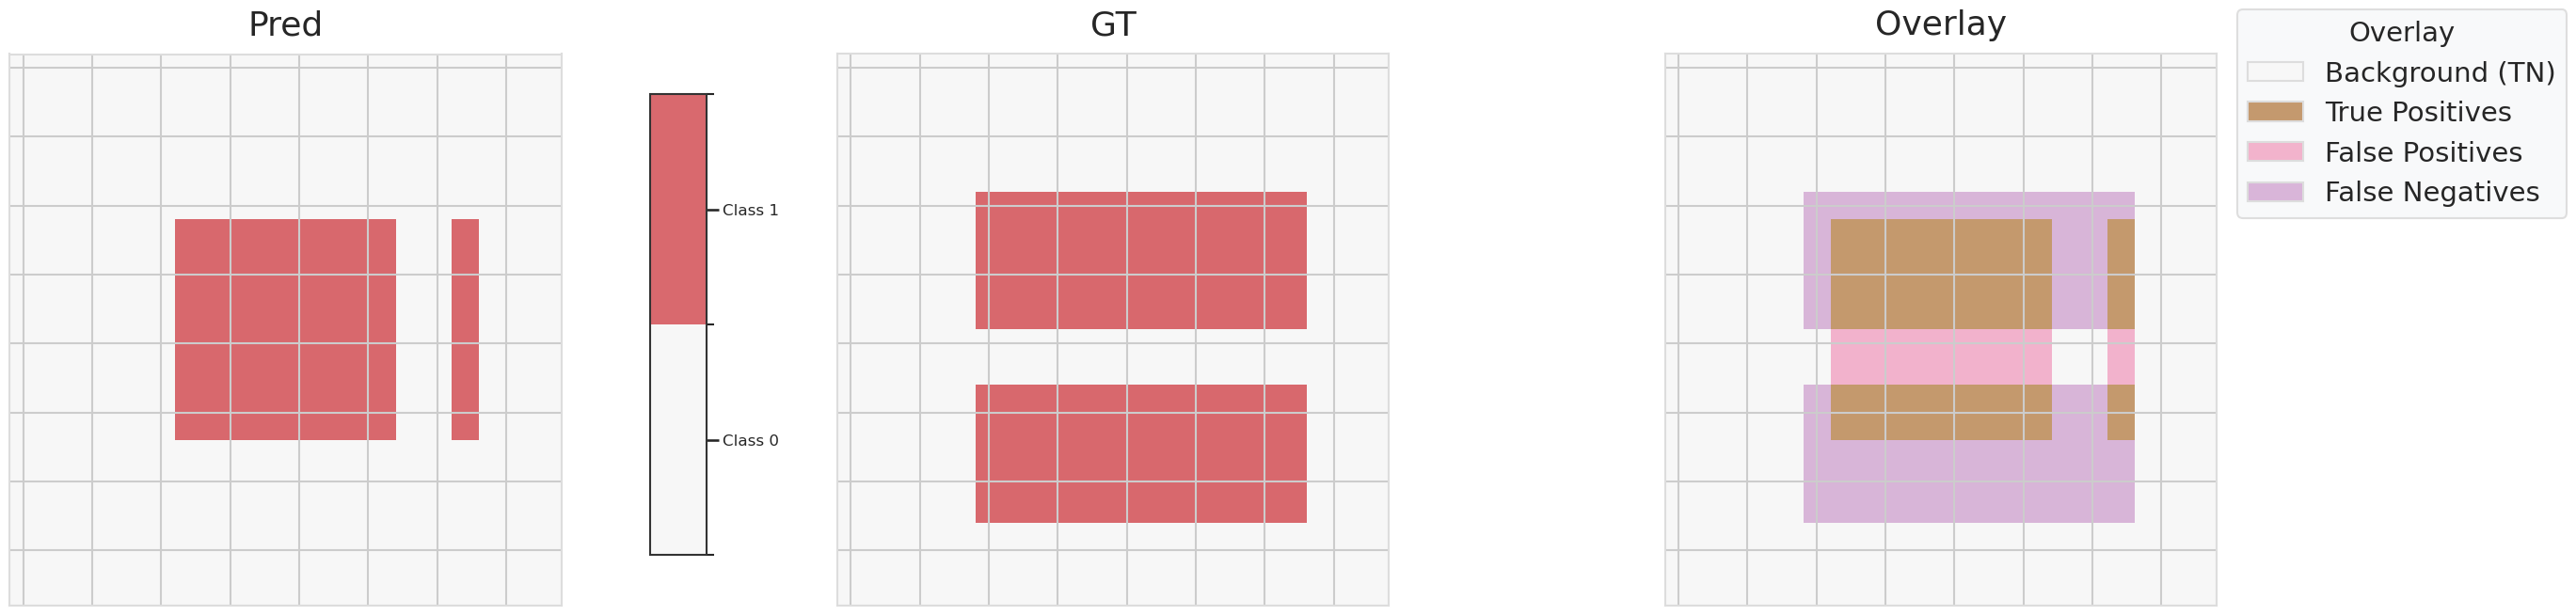

tensor([0.5625], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.287476 0.189065 0.367967
      CC 0.549754 0.391304 0.817853
      LW 0.409091 0.266447 0.553030
      MM 0.545455 0.375000 0.651515
       C 0.562500 0.391304 0.760417
     MMM 0.562500 0.391304 0.760417
       B 0.503289 0.346154 0.636111
Semantic 0.562500 0.391304 0.760417


In [16]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 16:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

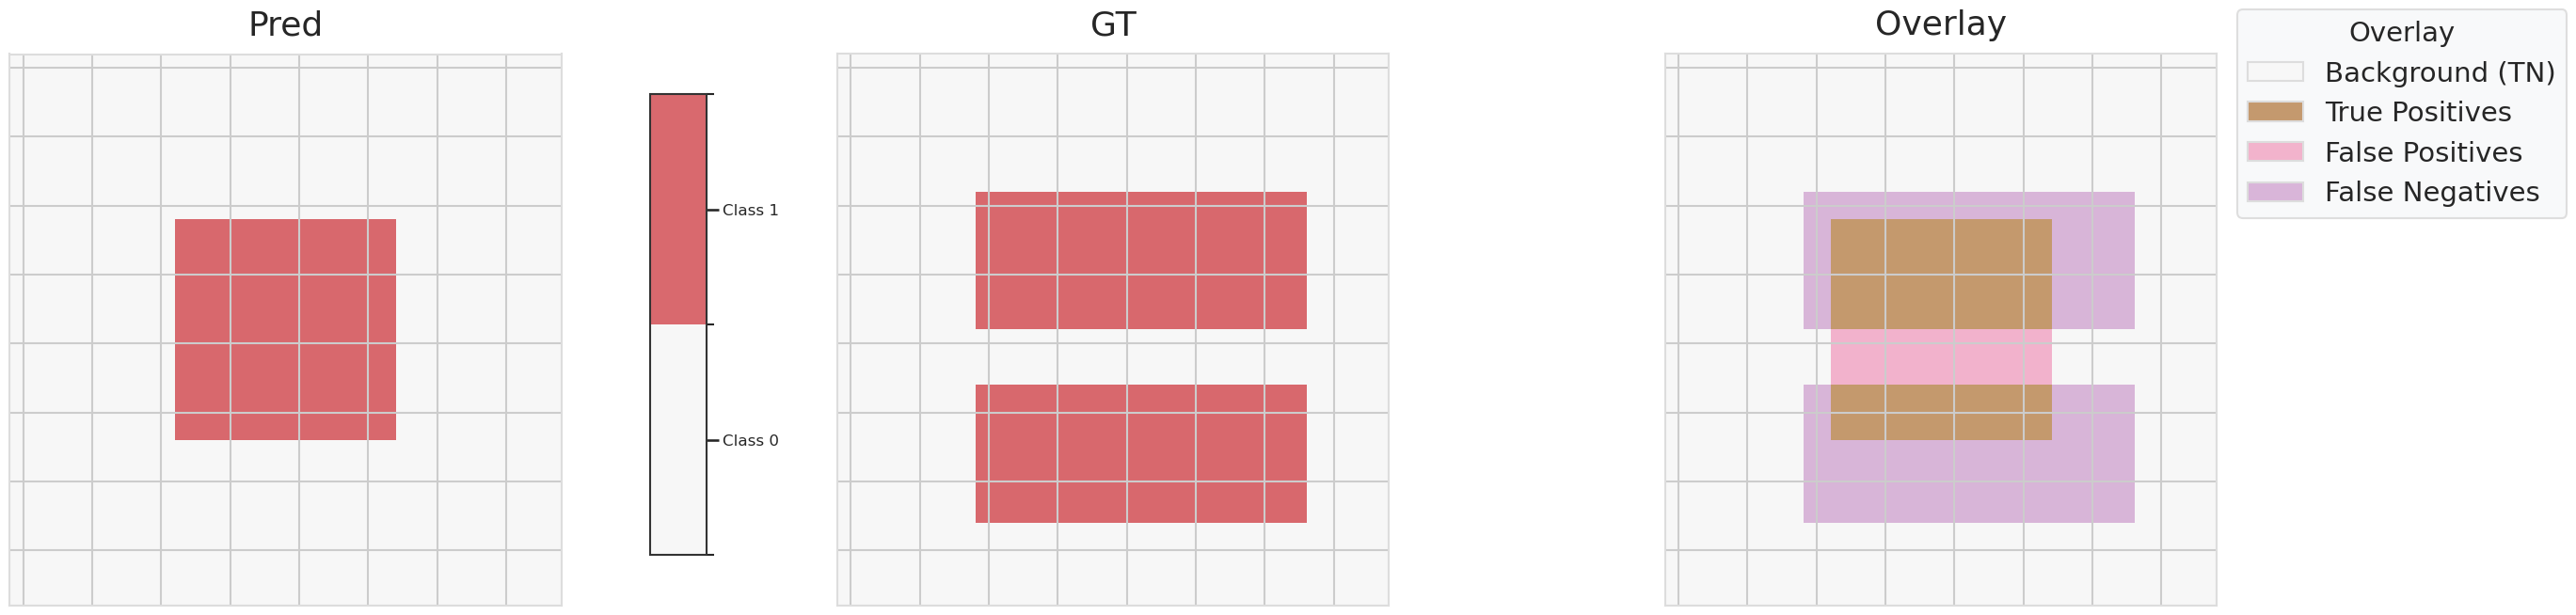

tensor([0.5217], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.516129 0.347826 0.551724
      CC 0.510476 0.352941 0.705930
      LW 0.387097 0.247987 0.474138
      MM 0.516129 0.347826 0.551724
       C 0.521739 0.352941 0.625000
     MMM 0.521739 0.352941 0.625000
       B 0.470209 0.315789 0.526296
Semantic 0.521739 0.352941 0.625000


In [17]:
# Sample Data with binary classes only
pred = torch.zeros((20, 20)).cuda()
gt = torch.zeros((20, 20)).cuda()

# Main GT
gt[5:10, 5:17] = 1
gt[12:17, 5:17] = 1

# Good Pred
pred[6:14, 6:14] = 1

plot_case(pred, gt, num_classes=2)
score_list(pred, gt)

# A nice way to showcase MM

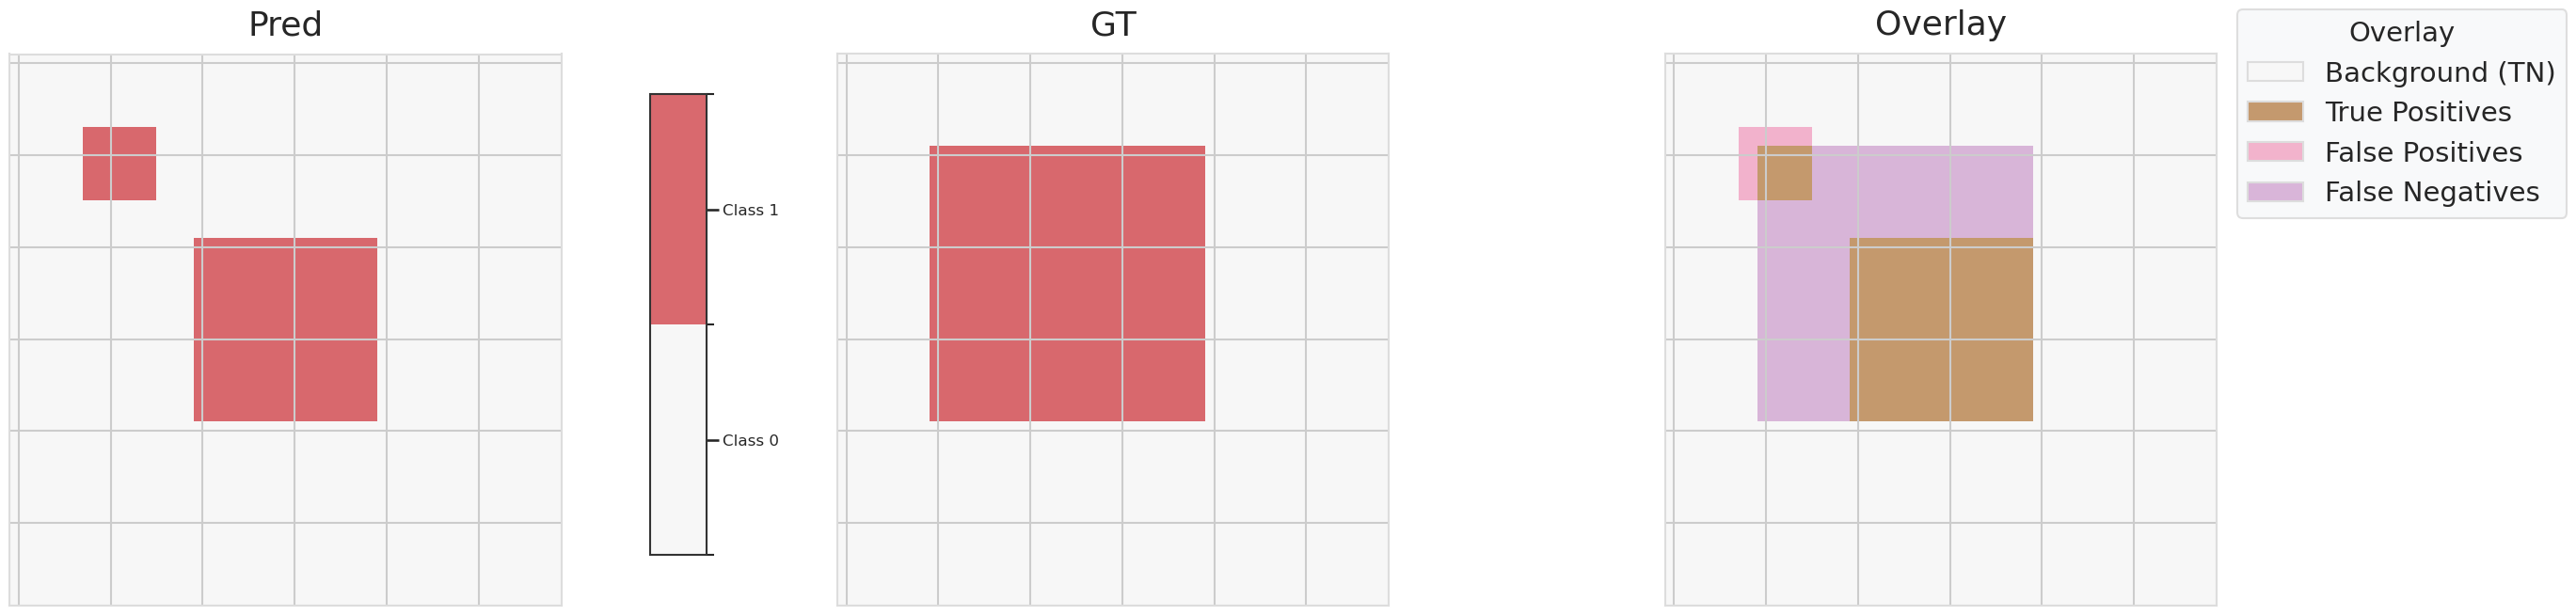

tensor([0.6393], device='cuda:0')
  Metric      dsc      iou      nsd
      PQ 0.615385 0.444444 0.456522
      CC 0.639296 0.469828 0.567308
      LW 0.639296 0.469828 0.567308
      MM 0.639296 0.469828 0.567308
       C 0.639296 0.469828 0.567308
     MMM 0.639296 0.469828 0.567308
       B 0.639296 0.469828 0.567308
Semantic 0.639296 0.469828 0.567308


In [18]:
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

pred[4:8, 4:8] = 1
pred[10:20, 10:20] = 1
gt[5:20, 5:20] = 1


plot_case(pred, gt, num_classes=2)
score_list(pred, gt)